In [3]:
# import bibliotek
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as ex
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [4]:
# formatowanie liczb zmiennoprzecinkowych
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [5]:
lds = pd.read_pickle("lds_tofeatures.pickle")

In [6]:
lds.shape

(2077928, 121)

In [7]:
X = lds.drop("loan_status",axis =1 )
y= lds["loan_status"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# we only transform X_test to stop any leakage 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
scores_dict = {

}

def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")


### XGBOOST

In [128]:
# import bibliotek
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [129]:
params = {
            'objective':'binary:logistic',
            #'max_depth': 4,
           # 'alpha': 10,
           # 'learning_rate': 1.0,
            'n_estimators':50,
            'n_jobs': -1,
            'use_label_encoder': False
        }         
           

In [130]:
# tworzenie obiektu klasyfikatora do trenowania modelu
model = xgb.XGBClassifier(**params)

In [131]:
# uruchomienie treningu modelu klasyfikacji
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [132]:
# predykcja na zbiorze testowym
y_pred = model.predict(X_test)

In [133]:
y_pred_train = model.predict(X_train)

In [134]:
# obliczenie dokładności modelu klasyfikacji
accuracy = accuracy_score(y_test, y_pred)

In [135]:
print_score(y_train, y_pred_train, train=True)
print_score(y_test, y_pred, train=False)

Train Result:
Accuracy Score: 87.97%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision      0.64033       0.88018   0.87970       0.76026       0.85119
recall         0.01055       0.99919   0.87970       0.50487       0.87970
f1-score       0.02076       0.93591   0.87970       0.47834       0.82531
support   168259.00000 1223952.00000   0.87970 1392211.00000 1392211.00000
_______________________________________________
Confusion Matrix: 
 [[   1775  166484]
 [    997 1222955]]

Test Result:
Accuracy Score: 88.03%
_______________________________________________
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision     0.52232      0.88097   0.88027      0.70165       0.83800
recall        0.00854      0.99894   0.88027      0.50374       0.88027
f1-score      0.01681      0.93625   0.88027      0.47653       0.82608
support   8216

In [37]:
# tworzenie wykresu krzywej ROC i obliczenie pola pod krzywą AUC
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

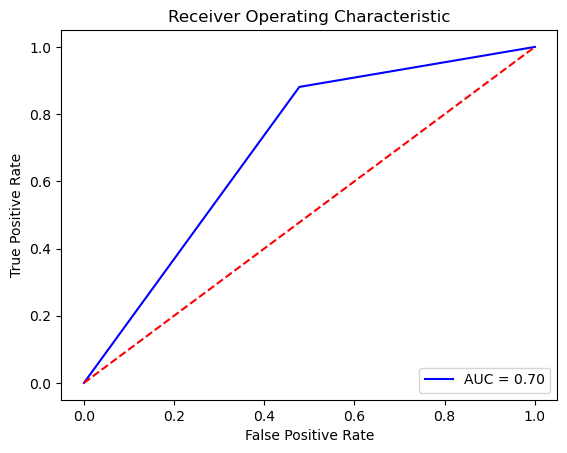

In [38]:
# generowanie wykresu krzywej ROC
buildROC(y_pred, y_test)

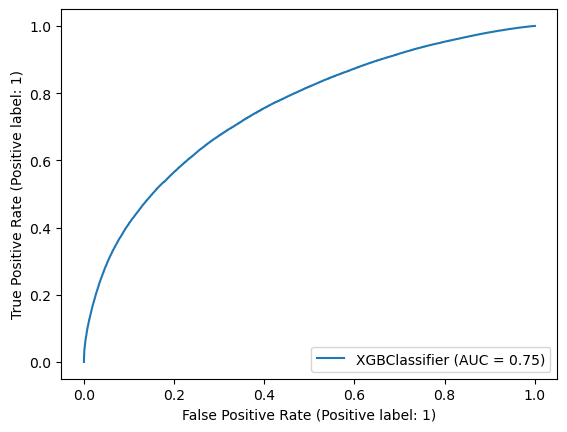

In [39]:
disp = RocCurveDisplay.from_estimator(model, X_test, y_test)

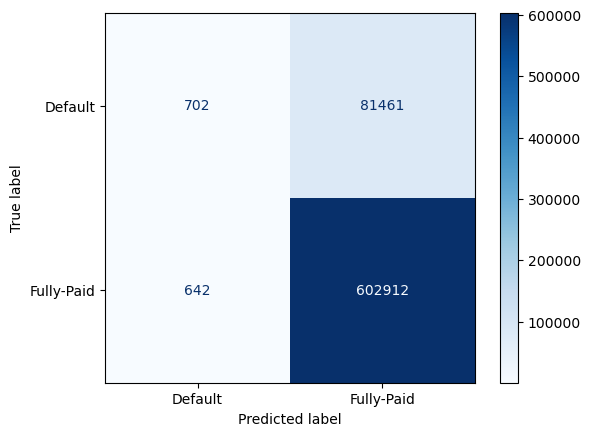

In [40]:
disp = ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

In [22]:
import shap
shap.initjs()

In [23]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [24]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])


In [25]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000,:])


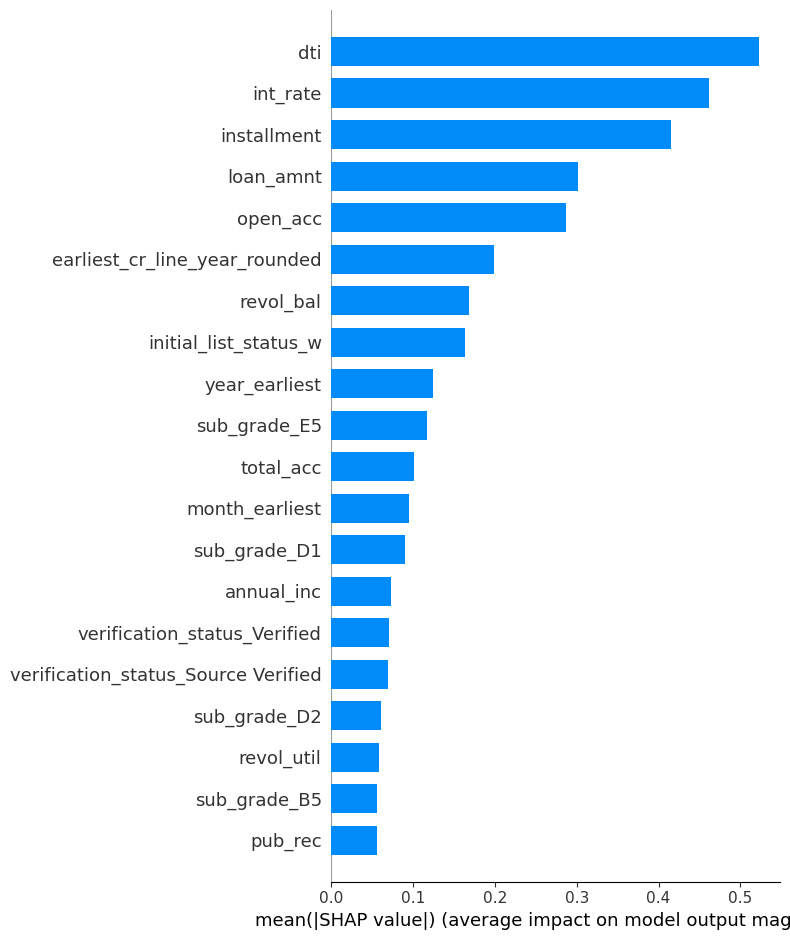

In [26]:
shap.summary_plot(shap_values, X, plot_type="bar")


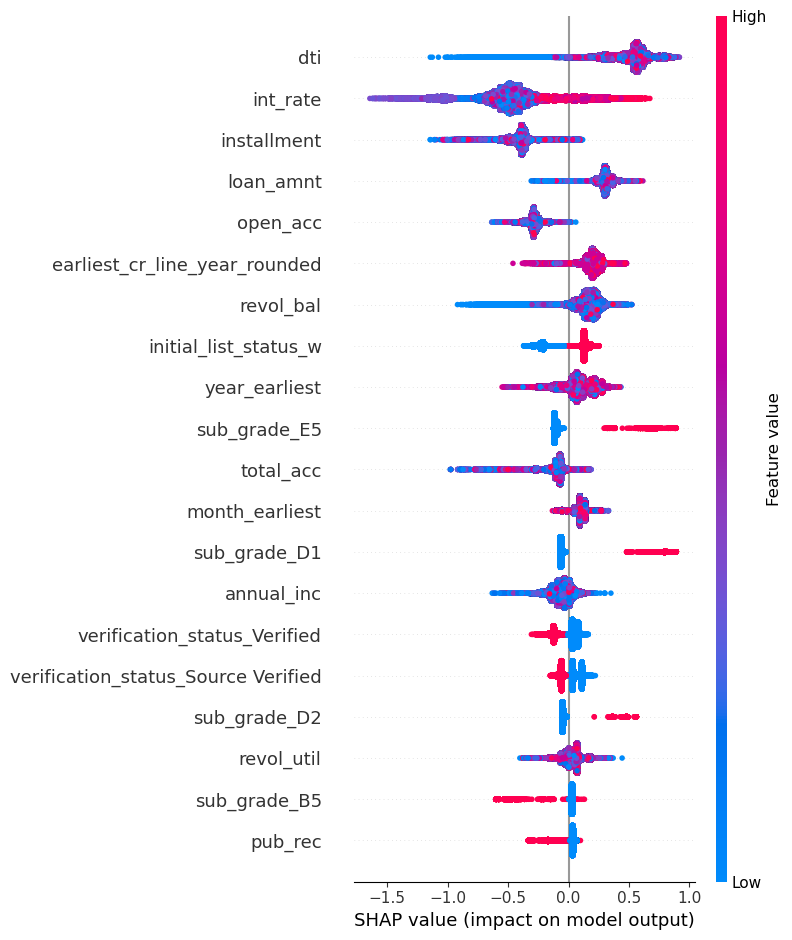

In [27]:
shap.summary_plot(shap_values, X)


In [41]:
scores_dict['XGBoost'] = {
        'Train': roc_auc_score(y_train, model.predict(X_train)),
        'Test': roc_auc_score(y_test, model.predict(X_test)),
    }

In [42]:
scores_df = pd.DataFrame(scores_dict)
scores_df.hvplot.barh(
    width=500, height=400, 
    title="ROC Scores of ML Models", xlabel="ROC Scores", 
    alpha=0.4, legend='top'
)

:Bars   [index]   (XGBoost)

#### cross validation

In [43]:
# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X_test,label=y_test)

In [44]:
from xgboost import cv

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)


In [45]:
xgb_cv.head(10)

train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.61793        0.00113        0.61717       0.00356
1         0.66686        0.02679        0.66567       0.02832
2         0.67747        0.02039        0.67574       0.02250
3         0.69072        0.01626        0.68943       0.01793
4         0.69513        0.00981        0.69370       0.01064
5         0.69734        0.00846        0.69568       0.00895
6         0.70149        0.00521        0.69966       0.00629
7         0.70407        0.00576        0.70221       0.00617
8         0.70688        0.00607        0.70514       0.00655
9         0.70783        0.00595        0.70600       0.00641

In [46]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [49]:
kfold = KFold(n_splits=5, random_state=7, shuffle=True)
results = cross_val_score(model, X_test, y_test, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 88.02% (0.06%)


## Random forest

In [50]:
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import roc_auc_score
import hvplot.pandas

### 1 drzewo

In [51]:
rf_clf_1_estimator = RandomForestClassifier(n_estimators=1)
rf_clf_1_estimator.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1)

In [52]:
y_train_pred_1_estimator = rf_clf_1_estimator.predict(X_train)
y_test_pred_1_estimator = rf_clf_1_estimator.predict(X_test)

In [53]:
print_score(y_train, y_train_pred_1_estimator, train=True)
print_score(y_test, y_test_pred_1_estimator, train=False)

Train Result:
Accuracy Score: 92.61%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision      0.69053       0.95926   0.92612       0.82489       0.92678
recall         0.70444       0.95660   0.92612       0.83052       0.92612
f1-score       0.69742       0.95793   0.92612       0.82767       0.92644
support   168259.00000 1223952.00000   0.92612 1392211.00000 1392211.00000
_______________________________________________
Confusion Matrix: 
 [[ 118529   49730]
 [  53121 1170831]]

Test Result:
Accuracy Score: 80.08%
_______________________________________________
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision     0.18582      0.88973   0.80078      0.53777       0.80538
recall        0.19596      0.88311   0.80078      0.53954       0.80078
f1-score      0.19076      0.88641   0.80078      0.53858       0.80305
support   8216

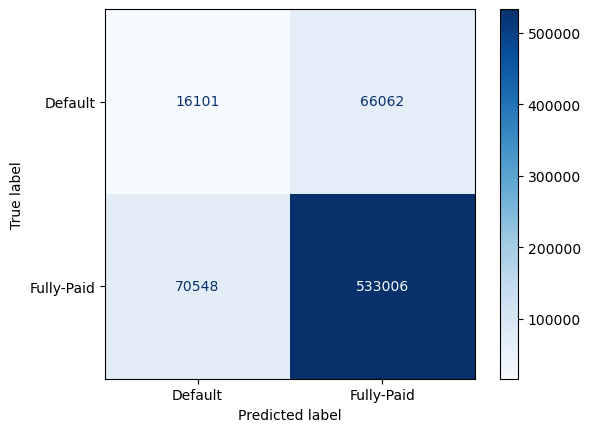

In [67]:
disp = ConfusionMatrixDisplay.from_estimator(rf_clf_1_estimator, X_test, y_test, 
                             cmap='Blues', values_format='d', 
                             display_labels=['Default', 'Fully-Paid'])

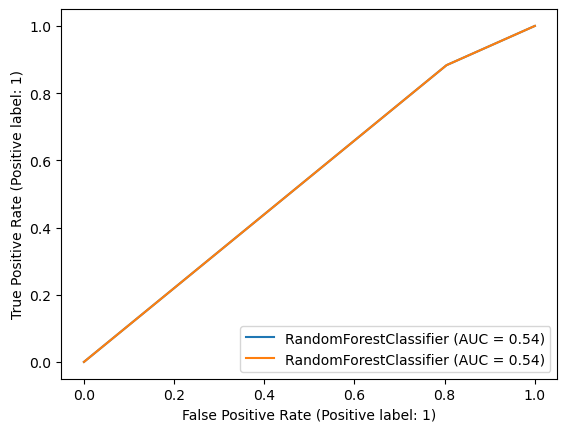

In [68]:
disp = RocCurveDisplay.from_estimator(rf_clf_1_estimator, X_test, y_test)
RocCurveDisplay.from_estimator(rf_clf_1_estimator, X_test, y_test, ax=disp.ax_)

In [69]:
scores_dict['Random Forest 1 estimator'] = {
        'Train': roc_auc_score(y_train, rf_clf_1_estimator.predict(X_train)),
        'Test': roc_auc_score(y_test, rf_clf_1_estimator.predict(X_test)),
    }

In [54]:
from sklearn.tree import DecisionTreeClassifier

In [55]:
dtc = DecisionTreeClassifier()

In [56]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [57]:
y_train_pred_dtree = dtc.predict(X_train)
y_test_pred_dtree = dtc.predict(X_test)

In [58]:
print_score(y_train, y_train_pred_dtree, train=True)
print_score(y_test, y_test_pred_dtree, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision      1.00000       1.00000   1.00000       1.00000       1.00000
recall         1.00000       1.00000   1.00000       1.00000       1.00000
f1-score       1.00000       1.00000   1.00000       1.00000       1.00000
support   168259.00000 1223952.00000   1.00000 1392211.00000 1392211.00000
_______________________________________________
Confusion Matrix: 
 [[ 168259       0]
 [      0 1223952]]

Test Result:
Accuracy Score: 80.15%
_______________________________________________
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision     0.20286      0.89286   0.80146      0.54786       0.81018
recall        0.22426      0.88003   0.80146      0.55215       0.80146
f1-score      0.21302      0.88640   0.80146      0.54971       0.80572
support   821

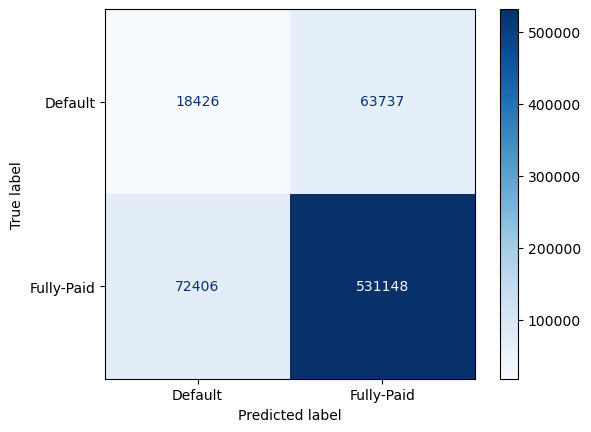

In [70]:
disp = ConfusionMatrixDisplay.from_estimator(dtc, X_test, y_test, 
                             cmap='Blues', values_format='d', 
                             display_labels=['Default', 'Fully-Paid'])

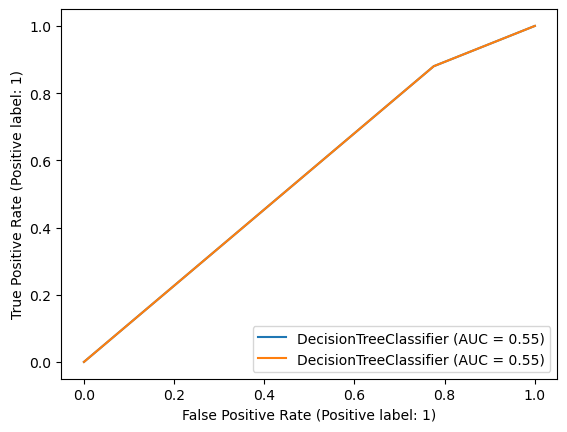

In [71]:
disp = RocCurveDisplay.from_estimator(dtc, X_test, y_test)
RocCurveDisplay.from_estimator(dtc, X_test, y_test, ax=disp.ax_)

In [72]:
scores_dict['Decision tree'] = {
        'Train': roc_auc_score(y_train, dtc.predict(X_train)),
        'Test': roc_auc_score(y_test, dtc.predict(X_test)),
    }

#### Random forest

In [60]:
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [61]:
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

In [62]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision      1.00000       0.99999   0.99999       0.99999       0.99999
recall         0.99990       1.00000   0.99999       0.99995       0.99999
f1-score       0.99995       0.99999   0.99999       0.99997       0.99999
support   168259.00000 1223952.00000   0.99999 1392211.00000 1392211.00000
_______________________________________________
Confusion Matrix: 
 [[ 168243      16]
 [      0 1223952]]

Test Result:
Accuracy Score: 88.02%
_______________________________________________
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision     0.51111      0.88080   0.88021      0.69595       0.83650
recall        0.00672      0.99913   0.88021      0.50292       0.88021
f1-score      0.01326      0.93624   0.88021      0.47475       0.82565
support   821

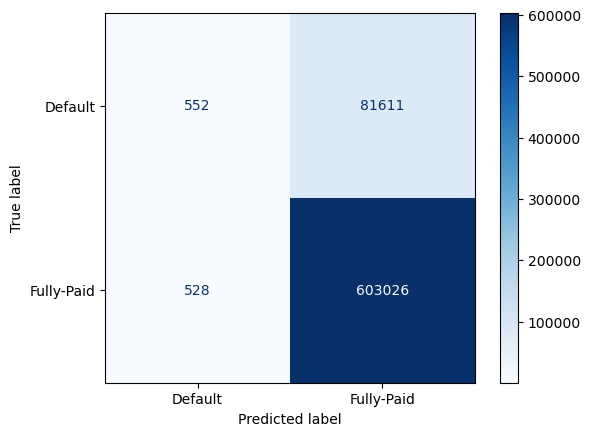

In [63]:
disp = ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, 
                             cmap='Blues', values_format='d', 
                             display_labels=['Default', 'Fully-Paid'])

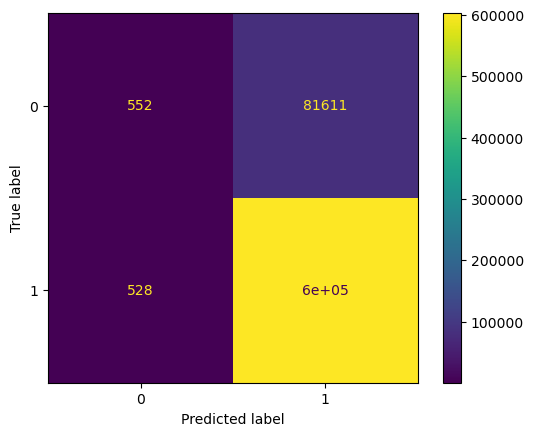

In [64]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

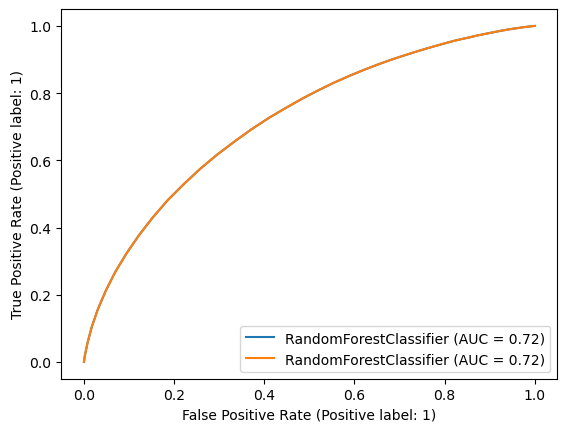

In [65]:
disp = RocCurveDisplay.from_estimator(rf_clf, X_test, y_test)
RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, ax=disp.ax_)

In [104]:
scores_dict['Random Forest'] = {
        'Train': roc_auc_score(y_train, rf_clf.predict(X_train)),
        'Test': roc_auc_score(y_test, rf_clf.predict(X_test)),
    }

### Log regression

https://www.datacamp.com/tutorial/understanding-logistic-regression-python

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [74]:
from sklearn.linear_model import LogisticRegression

In [75]:
logreg = LogisticRegression(random_state=16, n_jobs=-1)

In [ ]:
logreg.fit(X_train, y_train)

In [77]:
y_pred_logreg = logreg.predict(X_test)

In [78]:
y_train_logred = logreg.predict(X_train)

In [79]:
print_score(y_train, y_train_logred, train=True)

Train Result:
Accuracy Score: 87.88%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision      0.46113       0.88079   0.87877       0.67096       0.83007
recall         0.01836       0.99705   0.87877       0.50771       0.87877
f1-score       0.03532       0.93532   0.87877       0.48532       0.82655
support   168259.00000 1223952.00000   0.87877 1392211.00000 1392211.00000
_______________________________________________
Confusion Matrix: 
 [[   3090  165169]
 [   3611 1220341]]



In [136]:
print_score(y_test, y_pred_logreg, train=False)

Test Result:
Accuracy Score: 87.98%
_______________________________________________
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision     0.46499      0.88185   0.87984      0.67342       0.83190
recall        0.01867      0.99708   0.87984      0.50787       0.87984
f1-score      0.03590      0.93593   0.87984      0.48591       0.82809
support   82163.00000 603554.00000   0.87984 685717.00000  685717.00000
_______________________________________________
Confusion Matrix: 
 [[  1534  80629]
 [  1765 601789]]



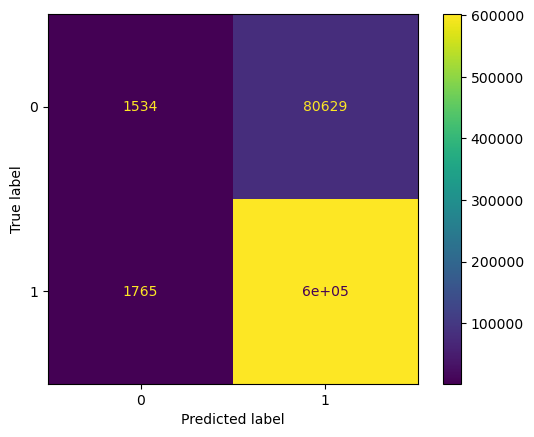

In [81]:
cm = confusion_matrix(y_test, y_pred_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

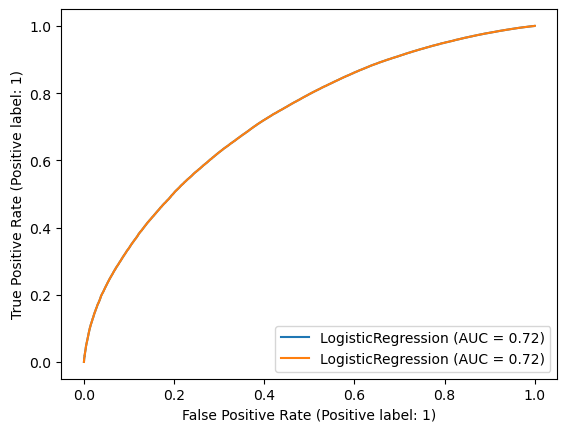

In [82]:
disp = RocCurveDisplay.from_estimator(logreg, X_test, y_test)
RocCurveDisplay.from_estimator(logreg, X_test, y_test, ax=disp.ax_)

In [83]:
scores_dict['Log regression'] = {
        'Train': roc_auc_score(y_train, logreg.predict(X_train)),
        'Test': roc_auc_score(y_test, logreg.predict(X_test)),
    }

### Unsupervised learning - knearest neighbors

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

https://realpython.com/knn-python/

In [89]:
from sklearn.neighbors import KNeighborsClassifier

In [84]:
lds_knn = lds.sample(500_000)

In [85]:
X_knn = lds_knn.drop("loan_status",axis =1 )
y_knn = lds_knn["loan_status"]

In [86]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.33, random_state=42)

In [87]:
scaler = MinMaxScaler()
# we only transform X_test to stop any leakage 
X_train_knn = scaler.fit_transform(X_train_knn)
X_test_knn = scaler.transform(X_test_knn)

In [90]:
neigh = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

In [91]:
neigh.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(n_jobs=-1)

In [92]:
y_train_nn = neigh.predict(X_train_knn)

In [93]:
y_pred_nn = neigh.predict(X_test_knn)

In [94]:
print_score(y_train_knn, y_train_nn, train=True)

Train Result:
Accuracy Score: 88.83%
_______________________________________________
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision     0.64032      0.89584   0.88827      0.76808       0.86517
recall        0.15796      0.98790   0.88827      0.57293       0.88827
f1-score      0.25341      0.93962   0.88827      0.59652       0.85725
support   40212.00000 294788.00000   0.88827 335000.00000  335000.00000
_______________________________________________
Confusion Matrix: 
 [[  6352  33860]
 [  3568 291220]]



In [137]:
print_score(y_test_knn, y_pred_nn, train=False)

Test Result:
Accuracy Score: 86.47%
_______________________________________________
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision     0.24248      0.88301   0.86468      0.56275       0.80577
recall        0.05755      0.97535   0.86468      0.51645       0.86468
f1-score      0.09302      0.92689   0.86468      0.50995       0.82634
support   19896.00000 145104.00000   0.86468 165000.00000  165000.00000
_______________________________________________
Confusion Matrix: 
 [[  1145  18751]
 [  3577 141527]]



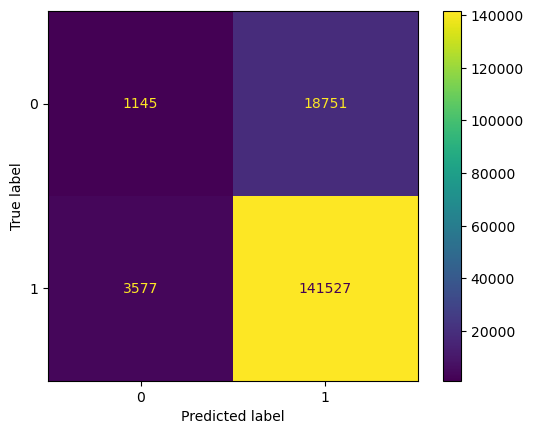

In [97]:
cm = confusion_matrix(y_test_knn, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

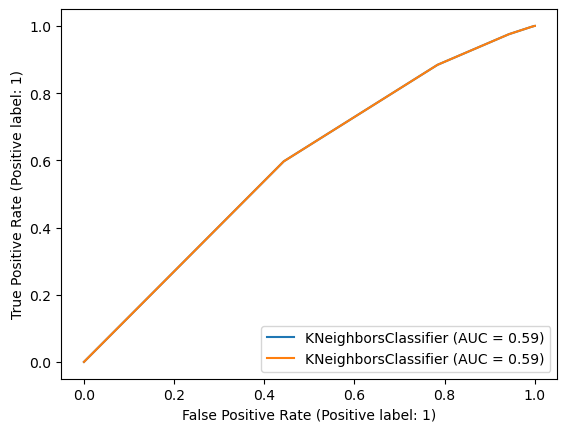

In [99]:
disp = RocCurveDisplay.from_estimator(neigh, X_test_knn, y_test_knn)
RocCurveDisplay.from_estimator(neigh, X_test_knn, y_test_knn, ax=disp.ax_)

In [101]:
scores_dict['KNearestN'] = {
        'Train': roc_auc_score(y_train_knn, neigh.predict(X_train_knn)),
        'Test': roc_auc_score(y_test_knn, neigh.predict(X_test_knn)),
    }

## Neural Network

In [106]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

In [107]:
def evaluate_nn(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [108]:
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during trainig')
    plt.legend();

In [109]:
def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model


In [110]:
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3

In [111]:
model = nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20


2023-08-11 23:59:10.085503: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


43507/43507 [==============================] - 85s 2ms/step - loss: 0.3421 - AUC: 0.6991 - val_loss: 0.3362 - val_AUC: 0.7205
Epoch 2/20
43507/43507 [==============================] - 85s 2ms/step - loss: 0.3365 - AUC: 0.7146 - val_loss: 0.3348 - val_AUC: 0.7261
Epoch 3/20
43507/43507 [==============================] - 84s 2ms/step - loss: 0.3352 - AUC: 0.7187 - val_loss: 0.3408 - val_AUC: 0.7265
Epoch 4/20
43507/43507 [==============================] - 84s 2ms/step - loss: 0.3346 - AUC: 0.7209 - val_loss: 0.3344 - val_AUC: 0.7298
Epoch 5/20
43507/43507 [==============================] - 84s 2ms/step - loss: 0.3342 - AUC: 0.7219 - val_loss: 0.3300 - val_AUC: 0.7324
Epoch 6/20
43507/43507 [==============================] - 84s 2ms/step - loss: 0.3338 - AUC: 0.7230 - val_loss: 0.3368 - val_AUC: 0.7259
Epoch 7/20
43507/43507 [==============================] - 84s 2ms/step - loss: 0.3335 - AUC: 0.7239 - val_loss: 0.3327 - val_AUC: 0.7293
Epoch 8/20
43507/43507 [============================

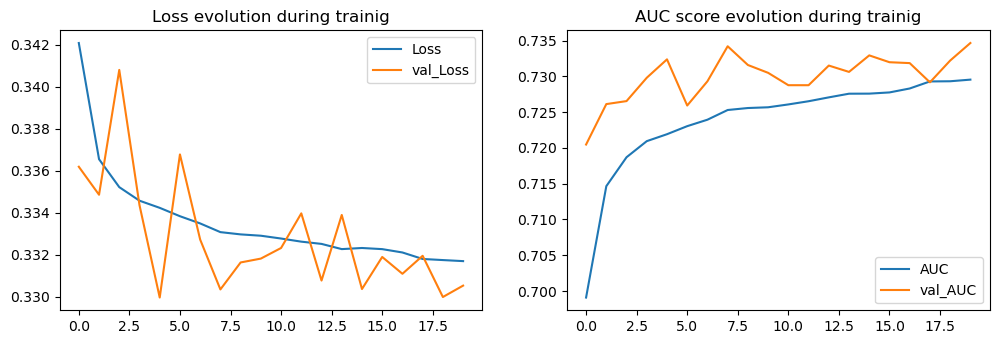

In [112]:
plot_learning_evolution(r)

In [113]:
y_train_pred = model.predict(X_train)
evaluate_nn(y_train, y_train_pred.round(), train=True)

43507/43507 [==============================] - 17s 392us/step
Train Result:
Accuracy Score: 87.85%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision      0.46659       0.88237   0.87852       0.67448       0.83212
recall         0.03574       0.99438   0.87852       0.51506       0.87852
f1-score       0.06639       0.93504   0.87852       0.50071       0.83005
support   168259.00000 1223952.00000   0.87852 1392211.00000 1392211.00000
_______________________________________________
Confusion Matrix: 
 [[   6013  162246]
 [   6874 1217078]]



In [114]:
y_test_pred = model.predict(X_test)
evaluate_nn(y_test, y_test_pred.round(), train=False)

21429/21429 [==============================] - 8s 386us/step
Test Result:
Accuracy Score: 87.94%
_______________________________________________
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision     0.45833      0.88336   0.87940      0.67085       0.83243
recall        0.03561      0.99427   0.87940      0.51494       0.87940
f1-score      0.06609      0.93554   0.87940      0.50081       0.83136
support   82163.00000 603554.00000   0.87940 685717.00000  685717.00000
_______________________________________________
Confusion Matrix: 
 [[  2926  79237]
 [  3458 600096]]



In [125]:
from sklearn.metrics import roc_curve, auc

21429/21429 [==============================] - 9s 406us/step


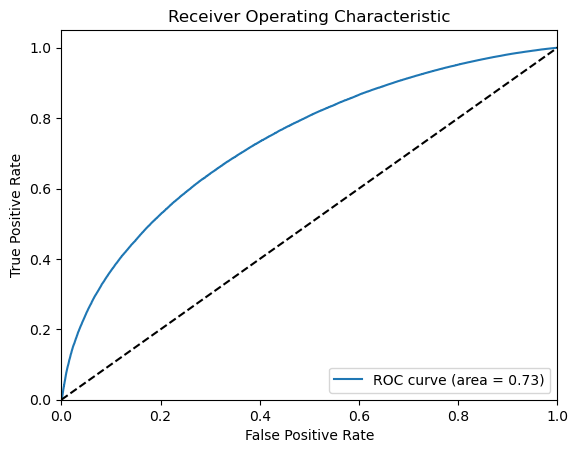

In [126]:
# Predict probabilities for testing set using TensorFlow model
y_pred_proba = model.predict(X_test)

# Calculate FPR, TPR, and thresholds using NumPy
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# Calculate AUC using scikit-learn
auc_score = auc(fpr, tpr)

# Plot ROC curve using Matplotlib
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [115]:
scores_dict = {
    'ANNs': {
        'Train': roc_auc_score(y_train, model.predict(X_train)),
        'Test': roc_auc_score(y_test, model.predict(X_test)),
    },
}

21429/21429 [==============================] - 8s 385us/step
